# Walmart Trip Type Classification
<img src="picture.png">

By: Daniela Schloeter and Jessica Fogerty

# Table of Contents

<a href='#Introduction'>1. Introduction</a>

<a href='#Understanding the Data'>2. Understanding the Data</a>

<a href='#Data Preprocessing part 1'>3. Data Preprocessing part 1</a>

<a href='#Exploratory Data Analysis'>4. Exploratory Data Analysis</a>

<a href='#Data Preprocessing part 2'>5. Data Preprocessing part 2</a>

<a href='#Feature Selection using Random Forest'>6. Feature Selection using Random Forest</a>

<a href='#Model Building'>6. Model Building</a>

<a href='#Conclusion'>7. Conclusion</a>

# Introduction
<a id='Introduction'></a>

As part of their efforts to improve customer service and create a better shopping experience, Walmart wants to segment their store visits into different trip types based on the combination of items that customers have purchased. They want to understand if a customer is going to shop for milk or clothes to be able to improve customer shopping experience. The goal of the project is to classify these customer trips by using only the transactional dataset and Market Basket Analysis of items that have been historically purchased.

Other segmenting problems have shown us how companies can strategically place products so that the customer has a better experience. For example, the classic diapers and beer example; thanks to analyzing the receipts from a grocery store it was found that a lot of people that went to buy diapers also purchased beer. If you place beer next to diapers you would be reminding those customers that they had forgotten the beer or simply hadn’t thought about it. The company could profit from this strategic product placement, and the customer has a better shopping experience because they remembered to purchase the beer. By solving Walmarts classification problem, they will be able to better understand how customers are making purchases and therefore plan a strategy based on the results.
To solve this categorization problem, Walmart has provided data for 7 variables; trip type, visit number, weekday, UPC, ScanCount, DepartmentDescription and FineLineNumber. The target variable is trip type. Walmart has already created 38 different categories of trip types. The data has been divided into training and testing datasets and it has a total of 1,300,702 observations

For this project we conducted an exploratory data analysis and experimented with different models and hyperparameter tuning by using data obtained from Kaggle.com. 

Attention: The outcome of the model building processes were produced by using Amazon Web Services due to the lack of computational power by our own personal laptops. Make sure to have this in mind when running this code. We used an Ubuntu EC2 instance with 8 CPUS and 32GB, this took 6+ hours to run.


# Import Packages

In [5]:
!pip install tensorflow as tf

     |████████████████████████████████| 105.8MB 101kB/s eta 0:00:01
  ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


In [6]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Load Data

In [4]:
dfpred = pd.read_csv("test.csv")
df = pd.read_csv("train.csv")

## Understanding the Data
<a id='Understanding the Data'></a>

In [3]:
dfpred.head()

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,1,Friday,7.250339e+10,1,SHOES,3002.0
1,1,Friday,1.707711e+09,1,DAIRY,1526.0
2,1,Friday,8.947000e+10,1,DAIRY,1431.0
3,1,Friday,8.849121e+10,1,GROCERY DRY GOODS,3555.0
4,2,Friday,2.840015e+09,1,DSD GROCERY,4408.0


In [4]:
df.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


In [5]:
print("Observations: " + str(dfpred.shape[0]))
print("Features: " + str(dfpred.shape[1]))

Observations: 653646
Features: 6


In [6]:
print("Observations: " + str(df.shape[0]))
print("Features: " + str(df.shape[1]))

Observations: 647054
Features: 7


dfpred has no "TripType" column so we will not use it to create our model but we will use it to predict.

# Data Preprocessing part 1
<a id='Data Preprocessing part 1'></a>

## Remove rows with missing values

In [7]:
df.isna().sum()

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64

In [8]:
df = df.dropna()
df.isna().sum()

TripType                 0
VisitNumber              0
Weekday                  0
Upc                      0
ScanCount                0
DepartmentDescription    0
FinelineNumber           0
dtype: int64

We are dropping instead of imputing because we don't want to bias our results. Each department description and combination of department description is extremely important to our model, imputing with the mode would leave room for bias. 

In [9]:
print("Observations remaining: " + str(df.shape[0]))
print("Features: " + str(df.shape[1]))

Observations remaining: 642925
Features: 7


# Exploratory Data Analysis
<a id='Exploratory Data Analysis'></a>

In [5]:
print('Features')
list(df)

Features


['TripType',
 'VisitNumber',
 'Weekday',
 'Upc',
 'ScanCount',
 'DepartmentDescription',
 'FinelineNumber']

In [11]:
print("Info of our dataset")
df.info()

Info of our dataset
<class 'pandas.core.frame.DataFrame'>
Int64Index: 642925 entries, 0 to 647053
Data columns (total 7 columns):
TripType                 642925 non-null int64
VisitNumber              642925 non-null int64
Weekday                  642925 non-null object
Upc                      642925 non-null float64
ScanCount                642925 non-null int64
DepartmentDescription    642925 non-null object
FinelineNumber           642925 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 39.2+ MB


In [12]:
print("Descriptive Statistics")
df.describe()

Descriptive Statistics


,TripType,VisitNumber,Upc,ScanCount,FinelineNumber
count,642925.000000,642925.000000,6.429250e+05,642925.000000,642925.000000
mean,58.337228,96199.870353,3.060698e+10,1.110203,3726.884567
std,156.559892,55552.836758,9.120134e+10,0.701240,2780.966158
min,3.000000,5.000000,8.340000e+02,-12.000000,0.000000
25%,27.000000,49300.000000,3.400001e+09,1.000000,1404.000000
50%,39.000000,97116.000000,7.050103e+09,1.000000,3352.000000
75%,40.000000,144353.000000,3.006531e+10,1.000000,5501.000000
max,999.000000,191347.000000,9.789707e+11,71.000000,9998.000000


In [13]:
for i in df:
    print('Unique values in ' + str(i)+':', df[i].nunique())
    
print()  


print('TripType')
print((df['TripType'].unique()))
print()
print('ScanCount')
print((df['ScanCount'].unique()))
print()
print('DepartmentDescription')
print((df['DepartmentDescription'].unique()))



Unique values in TripType: 38
Unique values in VisitNumber: 94247
Unique values in Weekday: 7
Unique values in Upc: 97714
Unique values in ScanCount: 39
Unique values in DepartmentDescription: 68
Unique values in FinelineNumber: 5195

TripType
[999  30  26   8  35  41  21   6  42   7   9  39  25  38  15  36  20  37
  32  40   5   3   4  24  33  43  31  27  34  18  29  44  19  23  22  28
  14  12]

ScanCount
[ -1   1   2   3   5   6   4  14  -2   9   7  10   8  -3  -5  11  16  -4
  13  15  30  12  20  -6 -12  19  46  23  -7  22  25  24  31  -9  51  17
  18  71 -10]

DepartmentDescription
['FINANCIAL SERVICES' 'SHOES' 'PERSONAL CARE' 'PAINT AND ACCESSORIES'
 'DSD GROCERY' 'MEAT - FRESH & FROZEN' 'DAIRY' 'PETS AND SUPPLIES'
 'HOUSEHOLD CHEMICALS/SUPP' 'IMPULSE MERCHANDISE' 'PRODUCE'
 'CANDY, TOBACCO, COOKIES' 'GROCERY DRY GOODS' 'BOYS WEAR'
 'FABRICS AND CRAFTS' 'JEWELRY AND SUNGLASSES' 'MENS WEAR' 'ACCESSORIES'
 'HOME MANAGEMENT' 'FROZEN FOODS' 'SERVICE DELI'
 'INFANT CONSUMABLE HARDLINE

Variable Description: TripType (38 unique) is the variable we are predicting, it is a categorical variable that distinguishes the trip type of the visit that was made to Walmart. VisitNumber (94247 unique visits) is the numerical value assigned to a single trip to Walmart, for example if I went to the store I could be VisitNumber 8 and all the items I purchase in that visit are purchased during visit number 8. Weekday is the day of the week that the visit occured. Upc is essentially the unique identifier for the product purchased, it is the barcode. ScanCount is the number of times a single item was scanned. For example if I purchesed 3 waters, the ScanCount would be 3. If I returned a pair of shoes, the ScanCount would be -1. The tricky part is that in the Market Basket Analysis, the items are listed in order of when the items were taken out of the "basket". If I placed three water bottles to be scanned first and then had two more at the bottom of my basket, then we see ScanCount 3 at the begining of the visit and ScanCount 2 at the end (for the same item), the total number is 5. DepartmentDescription is the description of the department that the item was purchased from. Fineline number is just a more refined classification for the item. 

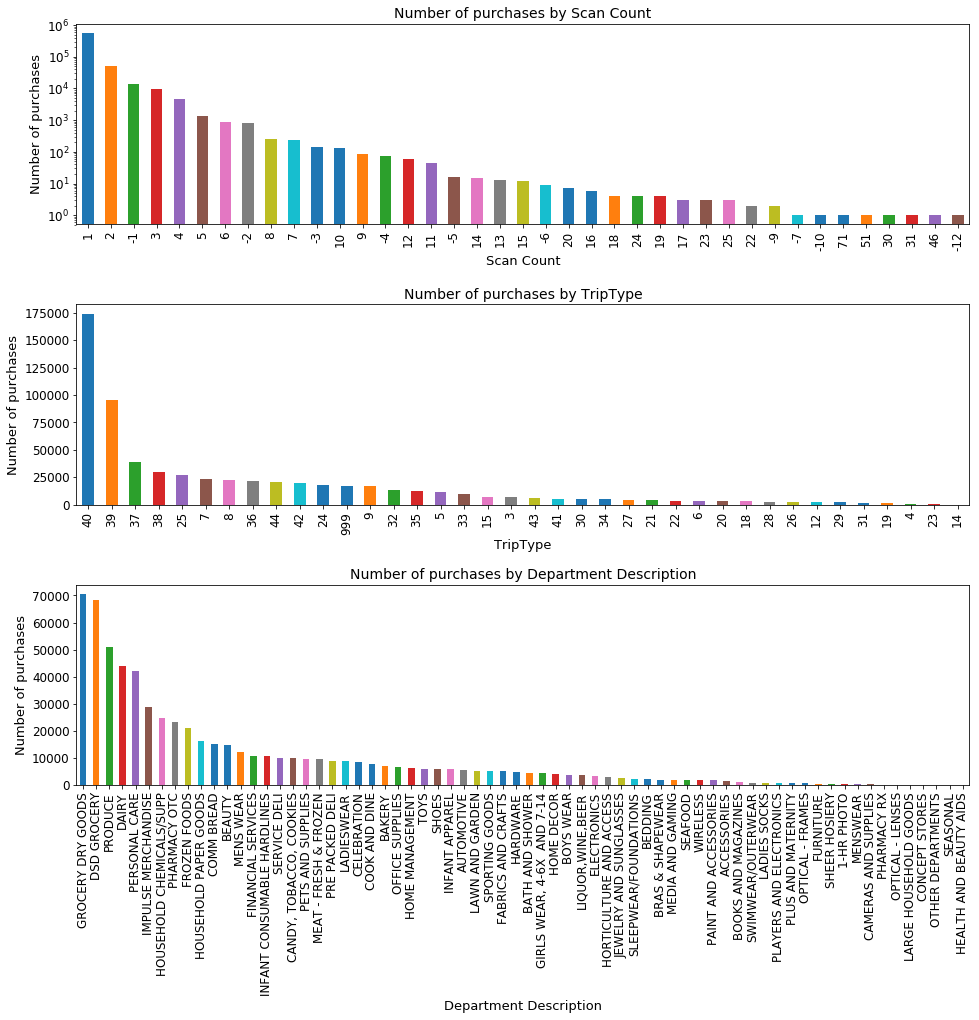

In [14]:
#Plotting purchases by Feature

#Set default paramaters for plots
fig = plt.figure(figsize=(16,14))
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['legend.fontsize']=12
plt.rcParams['lines.linewidth']=2

#Create subplots

ax3 = fig.add_subplot(311)
df.groupby(['ScanCount'], as_index=False).size().sort_values(ascending=False,axis=0).plot("bar",logy=True)
ax3.set_xlabel('Scan Count')
ax3.set_ylabel('Number of purchases')
ax3.set_title('Number of purchases by Scan Count')


ax1 = fig.add_subplot(312)
df.groupby(['TripType'], as_index=False).size().sort_values(ascending=False,axis=0).plot("bar")
ax1.set_xlabel('TripType')
ax1.set_ylabel('Number of purchases')
ax1.set_title('Number of purchases by TripType')

ax2 = fig.add_subplot(313)
df.groupby(['DepartmentDescription'], as_index=False).size().sort_values(ascending=False,axis=0).plot('bar')
ax2.set_xlabel('Department Description')
ax2.set_ylabel('Number of purchases')
ax2.set_title('Number of purchases by Department Description')




plt.subplots_adjust(hspace=.4)


The second plot depicts the number of purchases per Trip Type. As we can see Trip Type 40, 39, and 37 are the most commonly seen categories. We can also observe that the most commonly purchased Department Description categories (third plot) are Grocery type purchases. Perhaps these two features are correlated. The first plot, scan count, indicates that most items are only purchased one time in each visit.

Text(0.5, 1.0, 'observations per weekday')

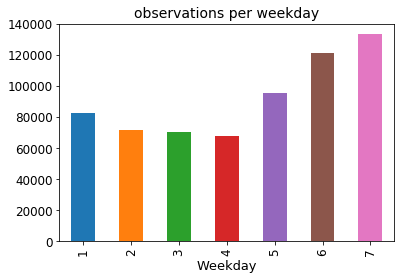

In [15]:
#How many purchases were made on a given day

# Enumerate days of the week

df = df.replace("Monday", 1)
df = df.replace("Tuesday", 2)
df = df.replace("Wednesday", 3)
df = df.replace("Thursday", 4)
df = df.replace("Friday", 5)
df = df.replace("Saturday", 6)
df = df.replace("Sunday", 7)


df_weekday =df.groupby("Weekday").count()
df_weekday['TripType'].plot(kind='bar')
plt.title("observations per weekday")

Most of the items were purchased on the weekend. 

Text(0.5, 1.0, 'Visits per weekday')

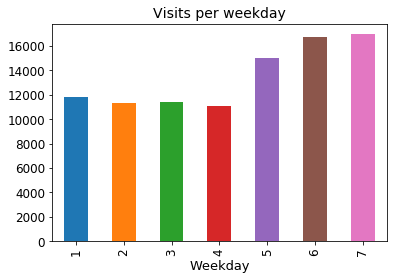

In [16]:
df_triptypes = df.drop_duplicates("VisitNumber")
df_triptypesw =df_triptypes.groupby("Weekday").count()
df_triptypesw['TripType'].plot(kind='bar')
plt.title("Visits per weekday")

The weekend is the most popular time for shoppers to shop at Walmart, Wednesday is the least popular day. We dropped duplicated visit numbers, each observation represents a purchase and not a unique visit. By dropping the duplicate visit numbers we can see how many visits walmart had each day of the week. 

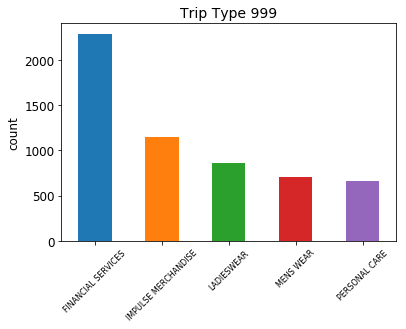

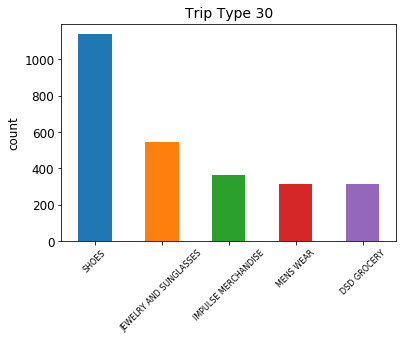

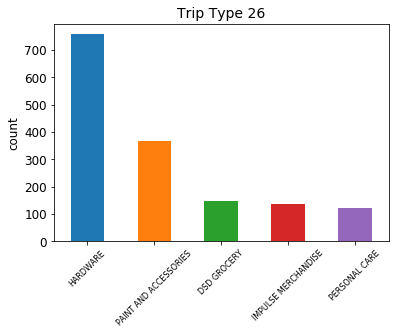

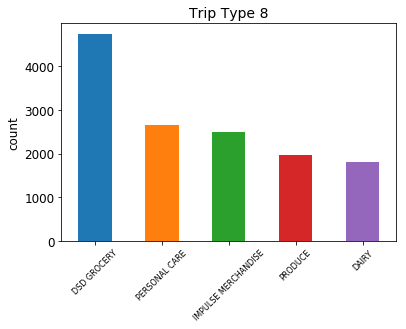

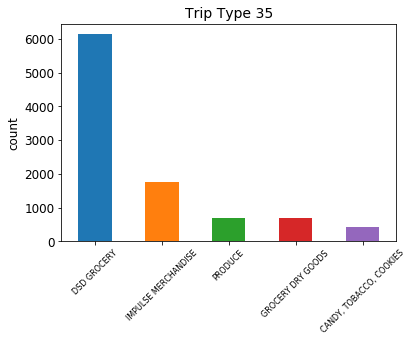

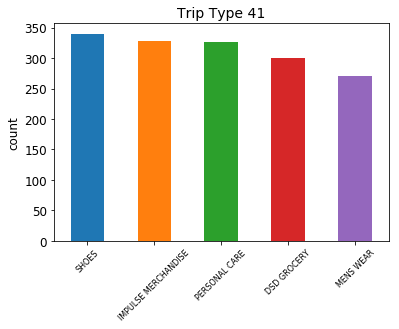

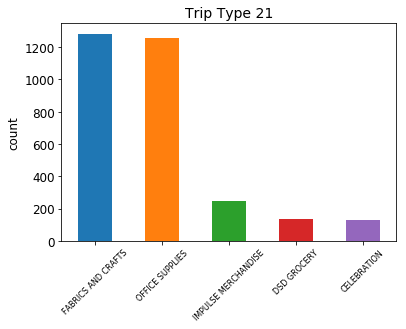

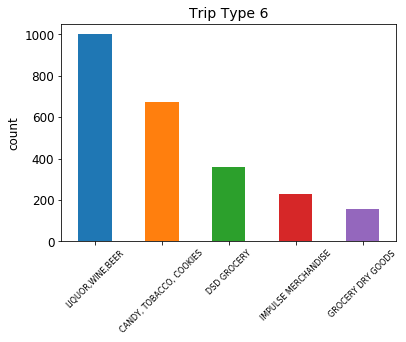

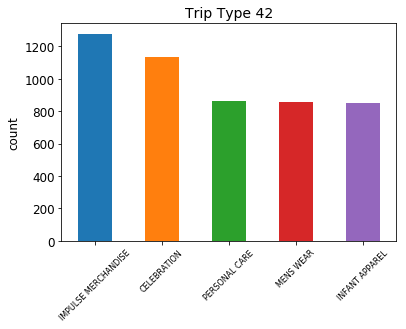

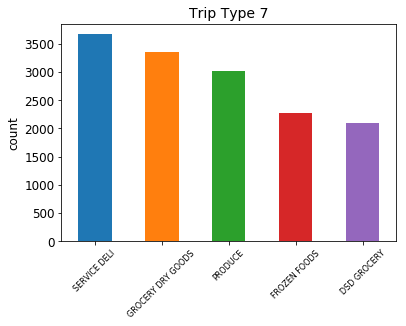

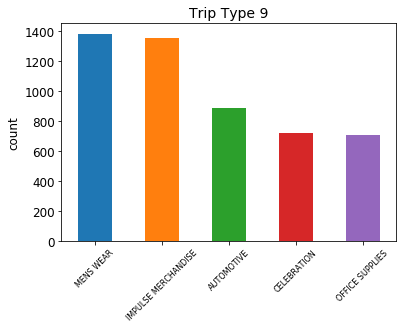

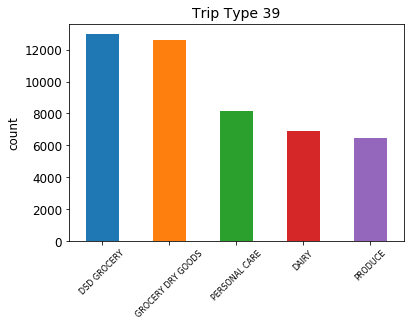

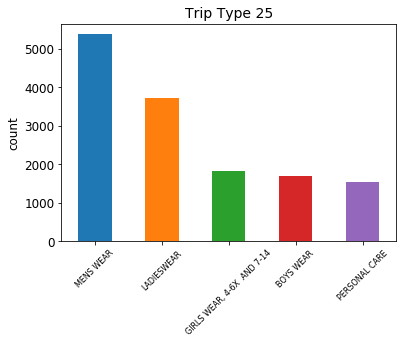

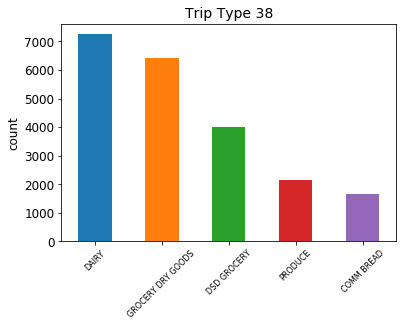

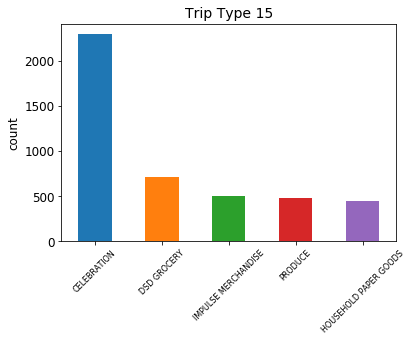

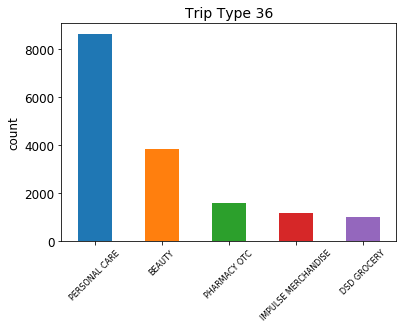

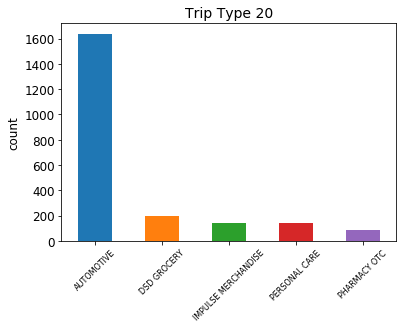

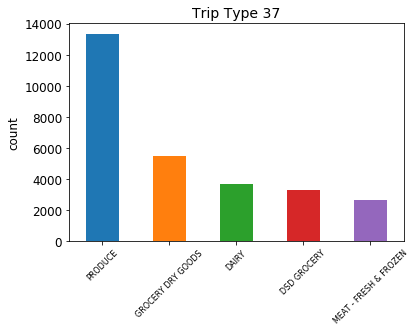

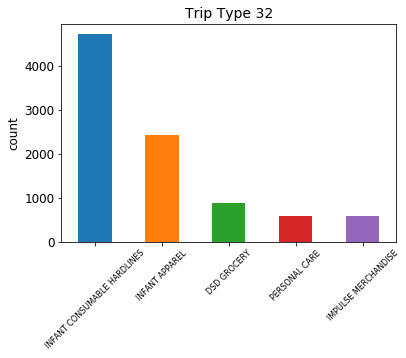

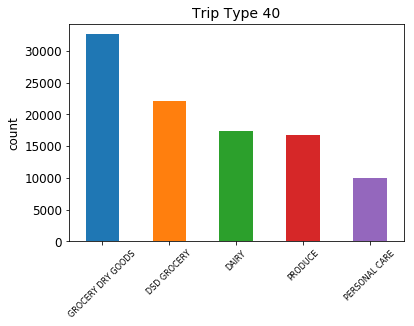

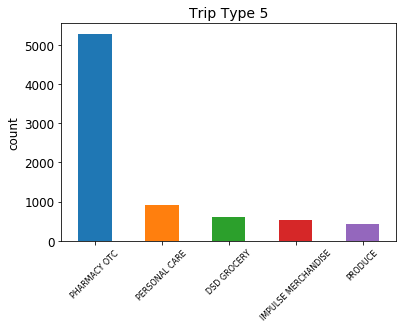

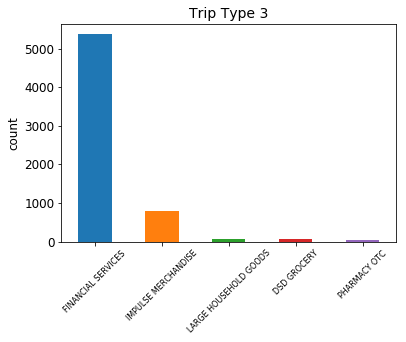

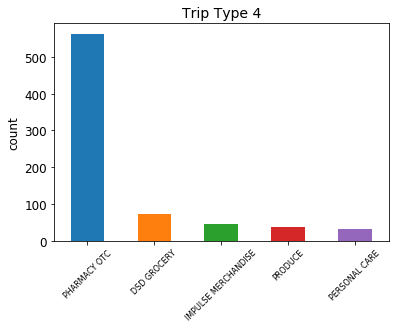

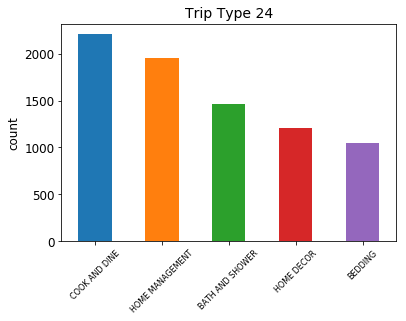

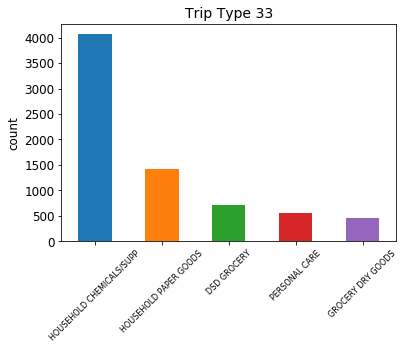

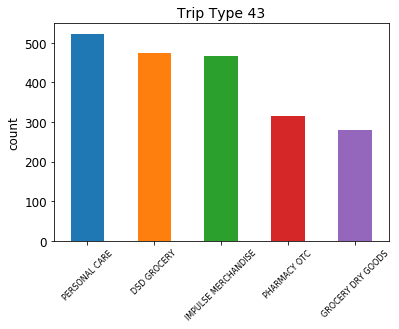

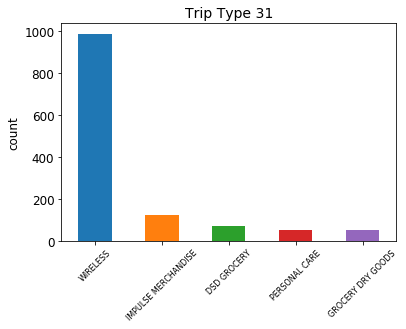

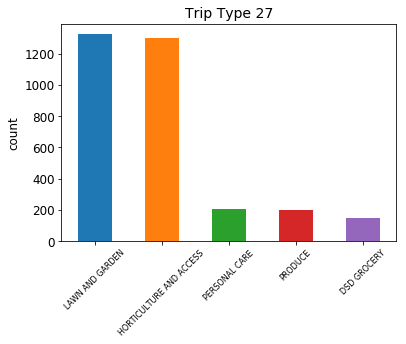

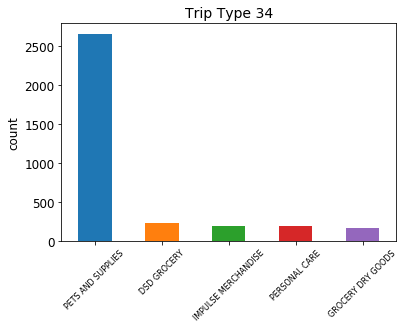

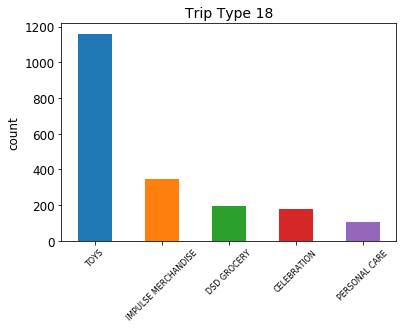

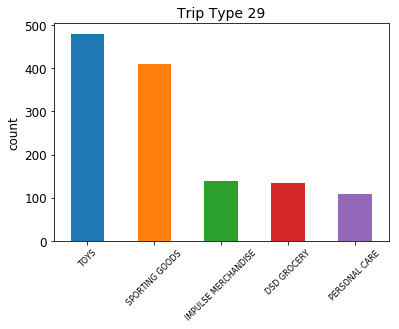

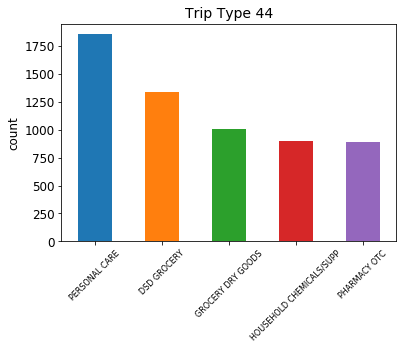

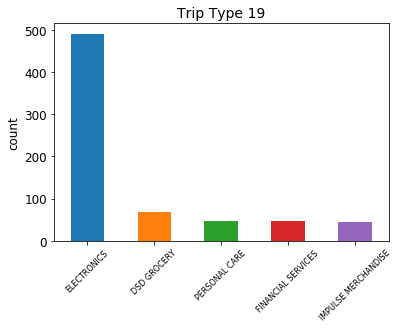

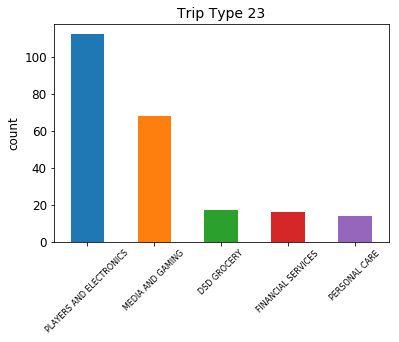

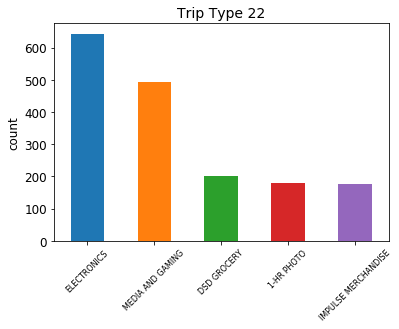

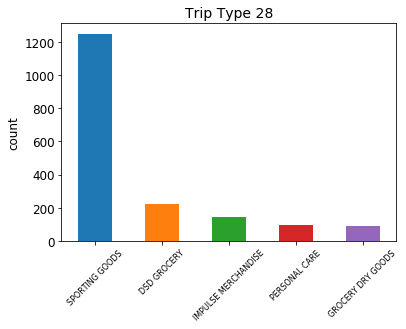

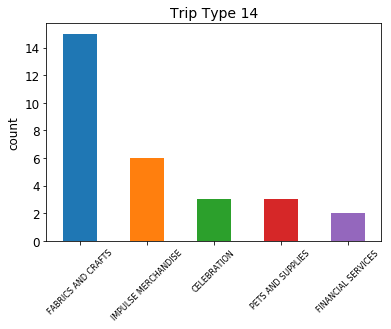

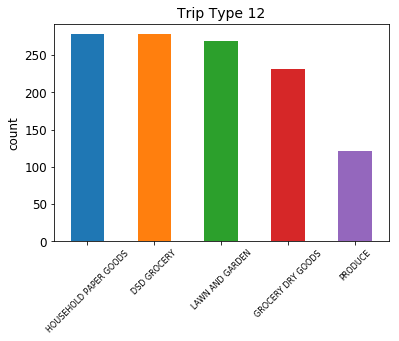

In [17]:
j=df['TripType'].unique()

for i in j:
    trip_type = df[df.TripType == i]
    trip_type_items = trip_type[["TripType", "DepartmentDescription"]]
    trip_type_items.DepartmentDescription.value_counts().head().plot(kind = "bar", rot=45, title = "Trip Type "+str(i))
    plt.xticks(fontsize=8)
    plt.ylabel('count', fontsize = 12)
    plt.show()


These charts give us an idea of which are the five most commonly purchased department for each trip type. 

The top 3 most popular trips are 8, 39 and 9. From the bar charts above we can infer that trip type 39 is more likely the weekly shopping list items. Trip type 8 it is an unplanned trip for missing items. Trip type 9 is more likely to be a male shopping trip. Although these are merly speculations it is helpful to understand the data better.

Text(0.5, 1.0, 'Number of visits by trip type')

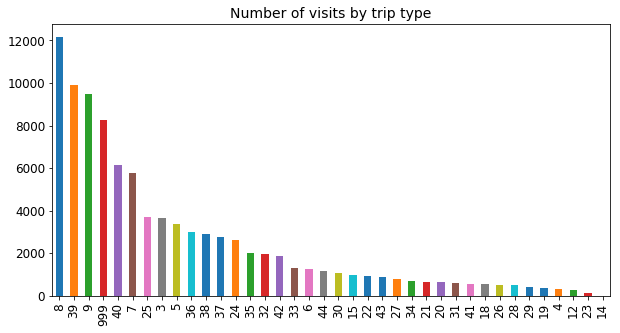

In [18]:
x=df_triptypes["TripType"]
x=x.value_counts()
graph = x.plot(kind="bar", figsize=(10, 5))
graph.set_title("Number of visits by trip type")


This plot indicates that trip type 8 sees the most visits in comparison to the chart above we see that trip type 39 sees the most variaty in items purchased. 


# Data Preprocessing part 2
<a id='Data Preprocessing part 2'></a>

## Encode the categorical features

In [19]:
categorical_features = ['DepartmentDescription']
new = pd.get_dummies(data=df, columns=categorical_features)

#group by scan count
new.columns
deptcolumns=['DepartmentDescription_1-HR PHOTO', 'DepartmentDescription_ACCESSORIES',
       'DepartmentDescription_AUTOMOTIVE', 'DepartmentDescription_BAKERY',
       'DepartmentDescription_BATH AND SHOWER', 'DepartmentDescription_BEAUTY',
       'DepartmentDescription_BEDDING',
       'DepartmentDescription_BOOKS AND MAGAZINES',
       'DepartmentDescription_BOYS WEAR',
       'DepartmentDescription_BRAS & SHAPEWEAR',
       'DepartmentDescription_CAMERAS AND SUPPLIES',
       'DepartmentDescription_CANDY, TOBACCO, COOKIES',
       'DepartmentDescription_CELEBRATION', 'DepartmentDescription_COMM BREAD',
       'DepartmentDescription_CONCEPT STORES',
       'DepartmentDescription_COOK AND DINE', 'DepartmentDescription_DAIRY',
       'DepartmentDescription_DSD GROCERY',
       'DepartmentDescription_ELECTRONICS',
       'DepartmentDescription_FABRICS AND CRAFTS',
       'DepartmentDescription_FINANCIAL SERVICES',
       'DepartmentDescription_FROZEN FOODS', 'DepartmentDescription_FURNITURE',
       'DepartmentDescription_GIRLS WEAR, 4-6X  AND 7-14',
       'DepartmentDescription_GROCERY DRY GOODS',
       'DepartmentDescription_HARDWARE',
       'DepartmentDescription_HEALTH AND BEAUTY AIDS',
       'DepartmentDescription_HOME DECOR',
       'DepartmentDescription_HOME MANAGEMENT',
       'DepartmentDescription_HORTICULTURE AND ACCESS',
       'DepartmentDescription_HOUSEHOLD CHEMICALS/SUPP',
       'DepartmentDescription_HOUSEHOLD PAPER GOODS',
       'DepartmentDescription_IMPULSE MERCHANDISE',
       'DepartmentDescription_INFANT APPAREL',
       'DepartmentDescription_INFANT CONSUMABLE HARDLINES',
       'DepartmentDescription_JEWELRY AND SUNGLASSES',
       'DepartmentDescription_LADIES SOCKS',
       'DepartmentDescription_LADIESWEAR',
       'DepartmentDescription_LARGE HOUSEHOLD GOODS',
       'DepartmentDescription_LAWN AND GARDEN',
       'DepartmentDescription_LIQUOR,WINE,BEER',
       'DepartmentDescription_MEAT - FRESH & FROZEN',
       'DepartmentDescription_MEDIA AND GAMING',
       'DepartmentDescription_MENS WEAR', 'DepartmentDescription_MENSWEAR',
       'DepartmentDescription_OFFICE SUPPLIES',
       'DepartmentDescription_OPTICAL - FRAMES',
       'DepartmentDescription_OPTICAL - LENSES',
       'DepartmentDescription_OTHER DEPARTMENTS',
       'DepartmentDescription_PAINT AND ACCESSORIES',
       'DepartmentDescription_PERSONAL CARE',
       'DepartmentDescription_PETS AND SUPPLIES',
       'DepartmentDescription_PHARMACY OTC',
       'DepartmentDescription_PHARMACY RX',
       'DepartmentDescription_PLAYERS AND ELECTRONICS',
       'DepartmentDescription_PLUS AND MATERNITY',
       'DepartmentDescription_PRE PACKED DELI',
       'DepartmentDescription_PRODUCE', 'DepartmentDescription_SEAFOOD',
       'DepartmentDescription_SEASONAL', 'DepartmentDescription_SERVICE DELI',
       'DepartmentDescription_SHEER HOSIERY', 'DepartmentDescription_SHOES',
       'DepartmentDescription_SLEEPWEAR/FOUNDATIONS',
       'DepartmentDescription_SPORTING GOODS',
       'DepartmentDescription_SWIMWEAR/OUTERWEAR',
       'DepartmentDescription_TOYS', 'DepartmentDescription_WIRELESS']
for i in deptcolumns:
    new[i] = new["ScanCount"] * new[i]

After inspecting the data we found out that in order to better predict the trip type we had to focus on the department and not the upc or fineline number. We proceeded to create dummy variables for the departmentdescription and add the sum of scan counts grouped by visitnumber for each department. We summed the scan counts because the combination of items purchased and the number of times that item was purchased in a given visit number is crucial in predicting trip type. Finally, we dropped Upc, ScanCount, FinelineNumber and VisitNumber because we do not want to have any posible identifiers when training our model.

In [20]:
new=new.groupby(['TripType','VisitNumber',"Weekday"]).sum()
new= new.reset_index(level=['TripType','Weekday','VisitNumber'])
new=new.drop(['Upc',"ScanCount",'FinelineNumber', "VisitNumber"],axis=1)
new.head(10)

,TripType,Weekday,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,DepartmentDescription_BEAUTY,DepartmentDescription_BEDDING,DepartmentDescription_BOOKS AND MAGAZINES,...,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS
0,3,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,3,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,3,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,3,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Get the features and the target

In [22]:
# Get the feature matrix
X =new.drop('TripType', axis=1)
feature_value_names = X.columns

# Get the target vector
y = new['TripType'].values
X.head()


,Weekday,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,DepartmentDescription_BEAUTY,DepartmentDescription_BEDDING,DepartmentDescription_BOOKS AND MAGAZINES,DepartmentDescription_BOYS WEAR,...,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Over sampling 

As it can be observed from the results below, we need to oversample and not undersample because our lowest class lable has 4 samples, if we were to undersample it we wouldn't have enough data to train the model. 

In [23]:
from imblearn.over_sampling import RandomOverSampler

# RandomOverSampler (with random_state=0)
print("Before over sampling")
print(pd.DataFrame(data=y, columns=['target'])['target'].value_counts())
ros = RandomOverSampler(random_state=0)
X, y = ros.fit_sample(X, y)

print("after over sampling")
print(pd.DataFrame(data=y, columns=['target'])['target'].value_counts())

Before over sampling
8      12161
39      9896
9       9464
999     8244
40      6130
7       5752
25      3698
3       3643
5       3366
36      3005
38      2912
37      2788
24      2609
35      2030
32      1984
42      1858
33      1315
6       1277
44      1187
30      1081
15       978
22       928
43       872
27       785
34       719
21       641
20       637
31       594
41       583
18       549
26       503
28       492
29       433
19       375
4        346
12       269
23       139
14         4
Name: target, dtype: int64
after over sampling
999    12161
15     12161
24     12161
23     12161
22     12161
21     12161
20     12161
19     12161
18     12161
14     12161
44     12161
12     12161
9      12161
8      12161
7      12161
6      12161
5      12161
4      12161
25     12161
26     12161
27     12161
28     12161
43     12161
42     12161
41     12161
40     12161
39     12161
38     12161
37     12161
36     12161
35     12161
34     12161
33     12161
32     12

## Feature Selection using Random Forest
<a id='Feature Selection using Random Forest'></a>

We began our model building process by exploring the feature importance by using a Random Forest model with KFold cross validation with n=5 splits. 

In [24]:
# Create the pipeline with StandardScaler and RandomForest

pipe_rf = Pipeline([('StandardScaler', StandardScaler()), ('RandomForestClassifier', RandomForestClassifier())])

scores = cross_val_score(pipe_rf,
                         X,
                         y,
                         cv=StratifiedKFold(n_splits=5,
                                            random_state=0))


pipe_rf.fit(X, y)

Pipeline(memory=None,
     steps=[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('RandomForestClassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [25]:
print('mean:', scores.mean())
print('std:', scores.std())

mean: 0.9197572612212277
std: 0.010374039273575008


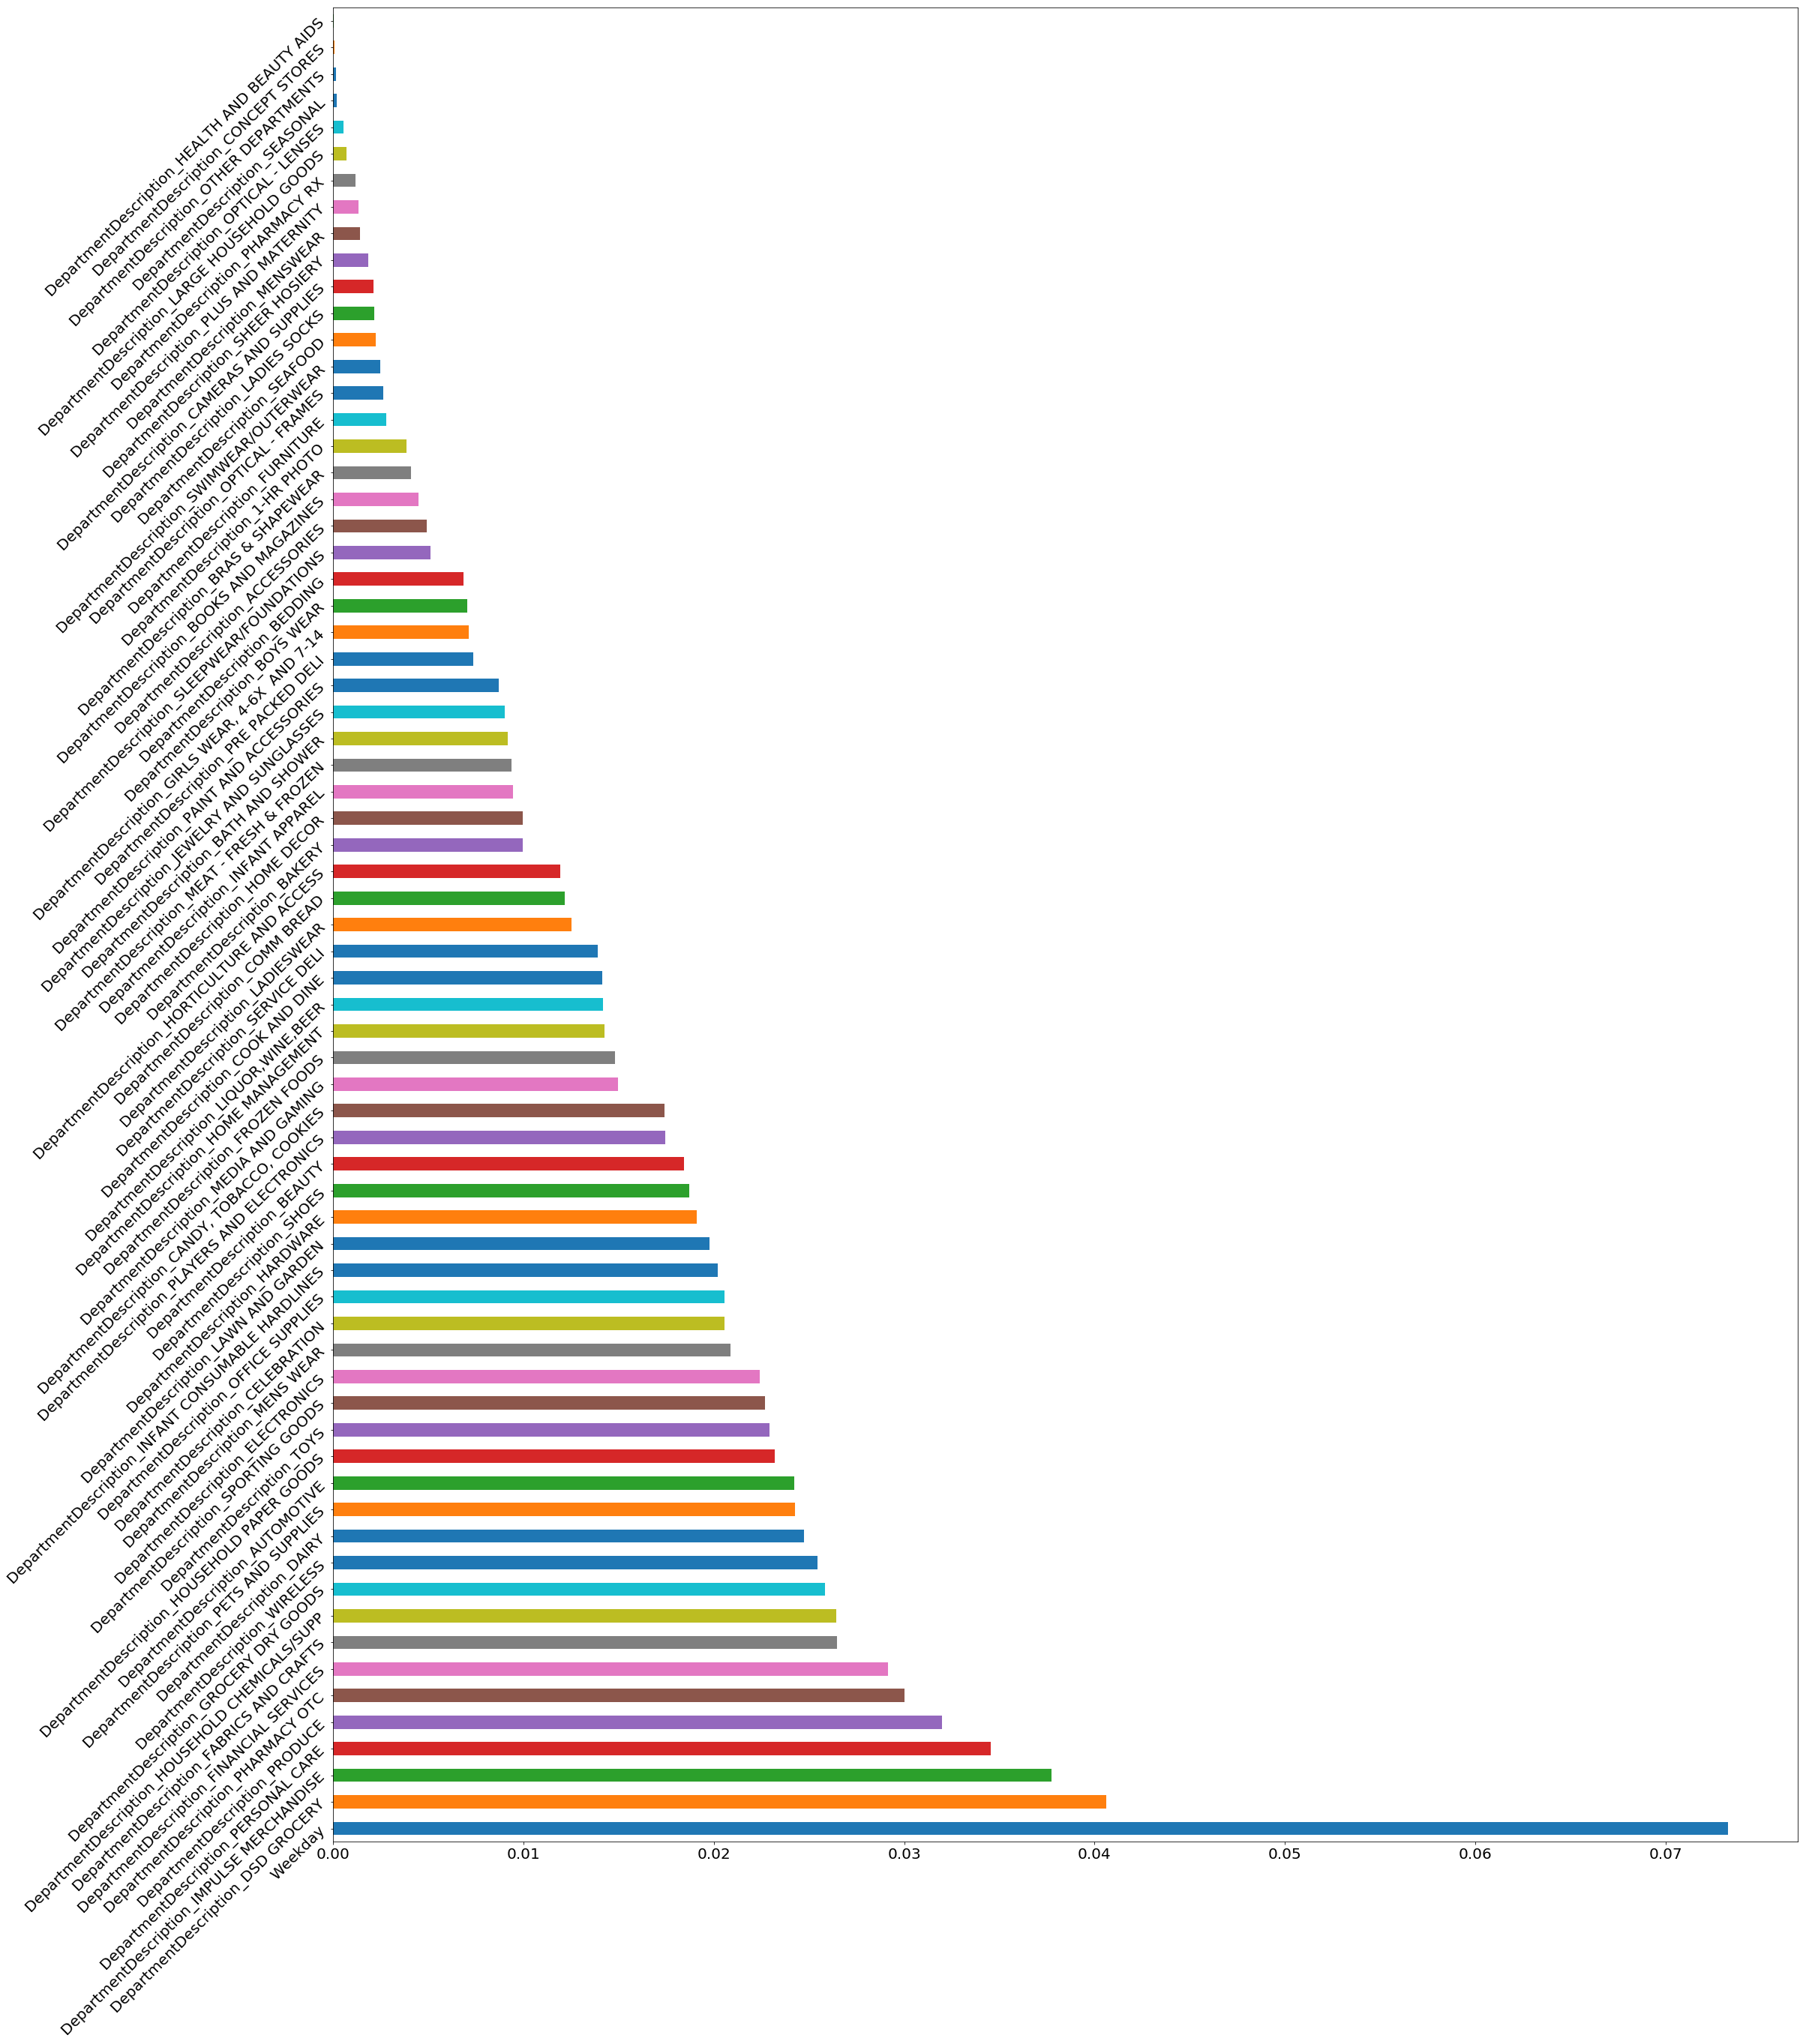

In [26]:
# Convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
f_importances = pd.Series(pipe_rf.named_steps['RandomForestClassifier'].feature_importances_, feature_value_names)

# Sort the array in descending order of the importances
f_importances = f_importances.sort_values(ascending=False)

# Draw the bar Plot from f_importances 
f_importances.plot(x='Importance', y='Features', kind='barh', figsize=(35,45), rot=45, fontsize=20)

#Show the plot

plt.show()

Next, we explore the robustness of the model after removing ten of the least important features, according to the feature importance bar chart above. This is done by running another Random Forest model after eliminating those less important features. 

In [27]:
Z =new.drop(['TripType','DepartmentDescription_HEALTH AND BEAUTY AIDS', 'DepartmentDescription_OTHER DEPARTMENTS'
          , 'DepartmentDescription_CONCEPT STORES','DepartmentDescription_SEASONAL','DepartmentDescription_OPTICAL - LENSES'
          ,'DepartmentDescription_LARGE HOUSEHOLD GOODS', 'DepartmentDescription_PHARMACY RX', 'DepartmentDescription_MENSWEAR',
          'DepartmentDescription_PLUS AND MATERNITY','DepartmentDescription_SHEER HOSIERY'], axis=1)

t = new['TripType'].values

Z.head()

,Weekday,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,DepartmentDescription_BEAUTY,DepartmentDescription_BEDDING,DepartmentDescription_BOOKS AND MAGAZINES,DepartmentDescription_BOYS WEAR,...,DepartmentDescription_PRE PACKED DELI,DepartmentDescription_PRODUCE,DepartmentDescription_SEAFOOD,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# Create the pipeline with StandardScaler and RandomForest

pipe_rf = Pipeline([('StandardScaler', StandardScaler()), ('RandomForestClassifier', RandomForestClassifier())])

scores = cross_val_score(pipe_rf,
                         Z,
                         t,
                         cv=StratifiedKFold(n_splits=5,
                                            random_state=0))

pipe_rf.fit(Z, t)

Pipeline(memory=None,
     steps=[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('RandomForestClassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [29]:
print('mean:', scores.mean())
print('std:', scores.std())

mean: 0.6000103422955958
std: 0.005243360047642466


By removing the least important features I wanted to see whether all of the features were important in the robustness of this model. It turns out that all the features are very important, which I assumed because we are taking into consideration combinations of DepartmentDescriptions in order to predict TripType. The model's accuracy reduced from 91% to 60%. 


# Model Building
<a id='Model Building'></a>

In [30]:
#Dictioary of Models
clfs = {'lr': LogisticRegression(random_state=0),
        'rf': RandomForestClassifier(random_state=0)}



We are not going to use support vector machine due to the extremely slow performance and lack of computing power. Even on AWS these two models took approximatley 6 hours to run.

In [31]:
#Build Pipeline
pipe_clfs = {}

for name, clf in clfs.items():
    
    pipe_clfs[name] = Pipeline([('StandardScaler', StandardScaler()), ('clf', clf)])

In [32]:
param_grids = {}

In [41]:
#parameter for logistic regression

C_range = [.1, 1, 10]

param_grid = [{'clf__C': C_range}]


param_grids['lr'] = param_grid

In [45]:
#parameter for random forest
param_grid = [{'clf__n_estimators': [2, 10, 30],
               'clf__min_samples_split': [2, 10, 30],
               'clf__min_samples_leaf': [1, 10, 30]}]

param_grids['rf'] = param_grid

## Classification Model using negative log loss as a scoring metric

In [46]:
#hyperparameter tuning

best_score_param_estimators = []

# For each classifier
for name in pipe_clfs.keys():

 
    gs = GridSearchCV(estimator=pipe_clfs[name],
                      param_grid=param_grids[name],
                      scoring='neg_log_loss',
                      n_jobs=-1,
                      cv=StratifiedKFold(n_splits=5,
                                         shuffle=True,
                                         random_state=0), refit=True)
    # Fit the pipeline
    
    gs = gs.fit(X, y)
    
    # Update best_score_param_estimators
    best_score_param_estimators.append([gs.best_score_, gs.best_params_, gs.best_estimator_])

In [47]:
#model selection
# Sort best_score_param_estimators in descending order of the best_score_

best_score_param_estimators = sorted(best_score_param_estimators, key=lambda x : x[0], reverse=True)

# For each [best_score_, best_params_, best_estimator_]
for best_score_param_estimator in best_score_param_estimators:
    # Print out [best_score_, best_params_, best_estimator_], where best_estimator_ is a pipeline
    # Since we only print out the type of classifier of the pipeline
    print([best_score_param_estimator[0], best_score_param_estimator[1], type(best_score_param_estimator[2].named_steps['clf'])], end='\n\n')

[-0.3521925559572034, {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 30}, <class 'sklearn.ensemble.forest.RandomForestClassifier'>]

[-1.4916105332259035, {'clf__C': 10}, <class 'sklearn.linear_model.logistic.LogisticRegression'>]



We can see here that Random Forest performs much better than Logistic Regression, scoring a negastive log loss of -.35 in comparison to -1.49. The best hyperparameters for Random Forest are a min_samples_leaf equal to 1, min_samples_split equal to 2 and n_estimators of 30. Logistic regression's best hyperparameter is C equals to 10. 

## Classification Model using accuracy as a scoring metric

In [48]:
#hyperparameter tuning
# The list of [best_score_, best_params_, best_estimator_]
best_score_param_estimators = []

# For each classifier
for name in pipe_clfs.keys():

    gs = GridSearchCV(estimator=pipe_clfs[name],
                      param_grid=param_grids[name],
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=StratifiedKFold(n_splits=5,
                                         shuffle=True,
                                         random_state=0), refit=True)
    # Fit the pipeline

    gs = gs.fit(X, y)
    
    # Update best_score_param_estimators
    best_score_param_estimators.append([gs.best_score_, gs.best_params_, gs.best_estimator_])

In [49]:
#model selection
# Sort best_score_param_estimators in descending order of the best_score_

best_score_param_estimators = sorted(best_score_param_estimators, key=lambda x : x[0], reverse=True)

# For each [best_score_, best_params_, best_estimator_]
for best_score_param_estimator in best_score_param_estimators:
    # Print out [best_score_, best_params_, best_estimator_], where best_estimator_ is a pipeline
    # Since we only print out the type of classifier of the pipeline
    print([best_score_param_estimator[0], best_score_param_estimator[1], type(best_score_param_estimator[2].named_steps['clf'])], end='\n\n')

[0.9190423225236845, {'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 30}, <class 'sklearn.ensemble.forest.RandomForestClassifier'>]

[0.61098464028668, {'clf__C': 10}, <class 'sklearn.linear_model.logistic.LogisticRegression'>]



Here we see that Random Forest still out performs Logistic Regression, with an accuracy of 91.9% in comparison to 61%. Both models had the same best hyperparameters as seen in the Classification model above (using negative log loss as a scoring metric).

# Rebuild Random Forest Model with Best Hyperparameters 

In [54]:
# pipeline with StandardScaler and best Hyperparameter

pipe_rf = Pipeline([('StandardScaler', StandardScaler()), ('RandomForestClassifier', RandomForestClassifier(min_samples_leaf=1, min_samples_split=2, n_estimators=30))])

scores = cross_val_score(pipe_rf,
                         X,
                         y,
                         cv=StratifiedKFold(n_splits=5,
                                            random_state=0))


pipe_rf.fit(X, y)

Pipeline(memory=None,
     steps=[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('RandomForestClassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [55]:
print('mean:', scores.mean())
print('std:', scores.std())


mean: 0.9221201450251788
std: 0.009648754767421778


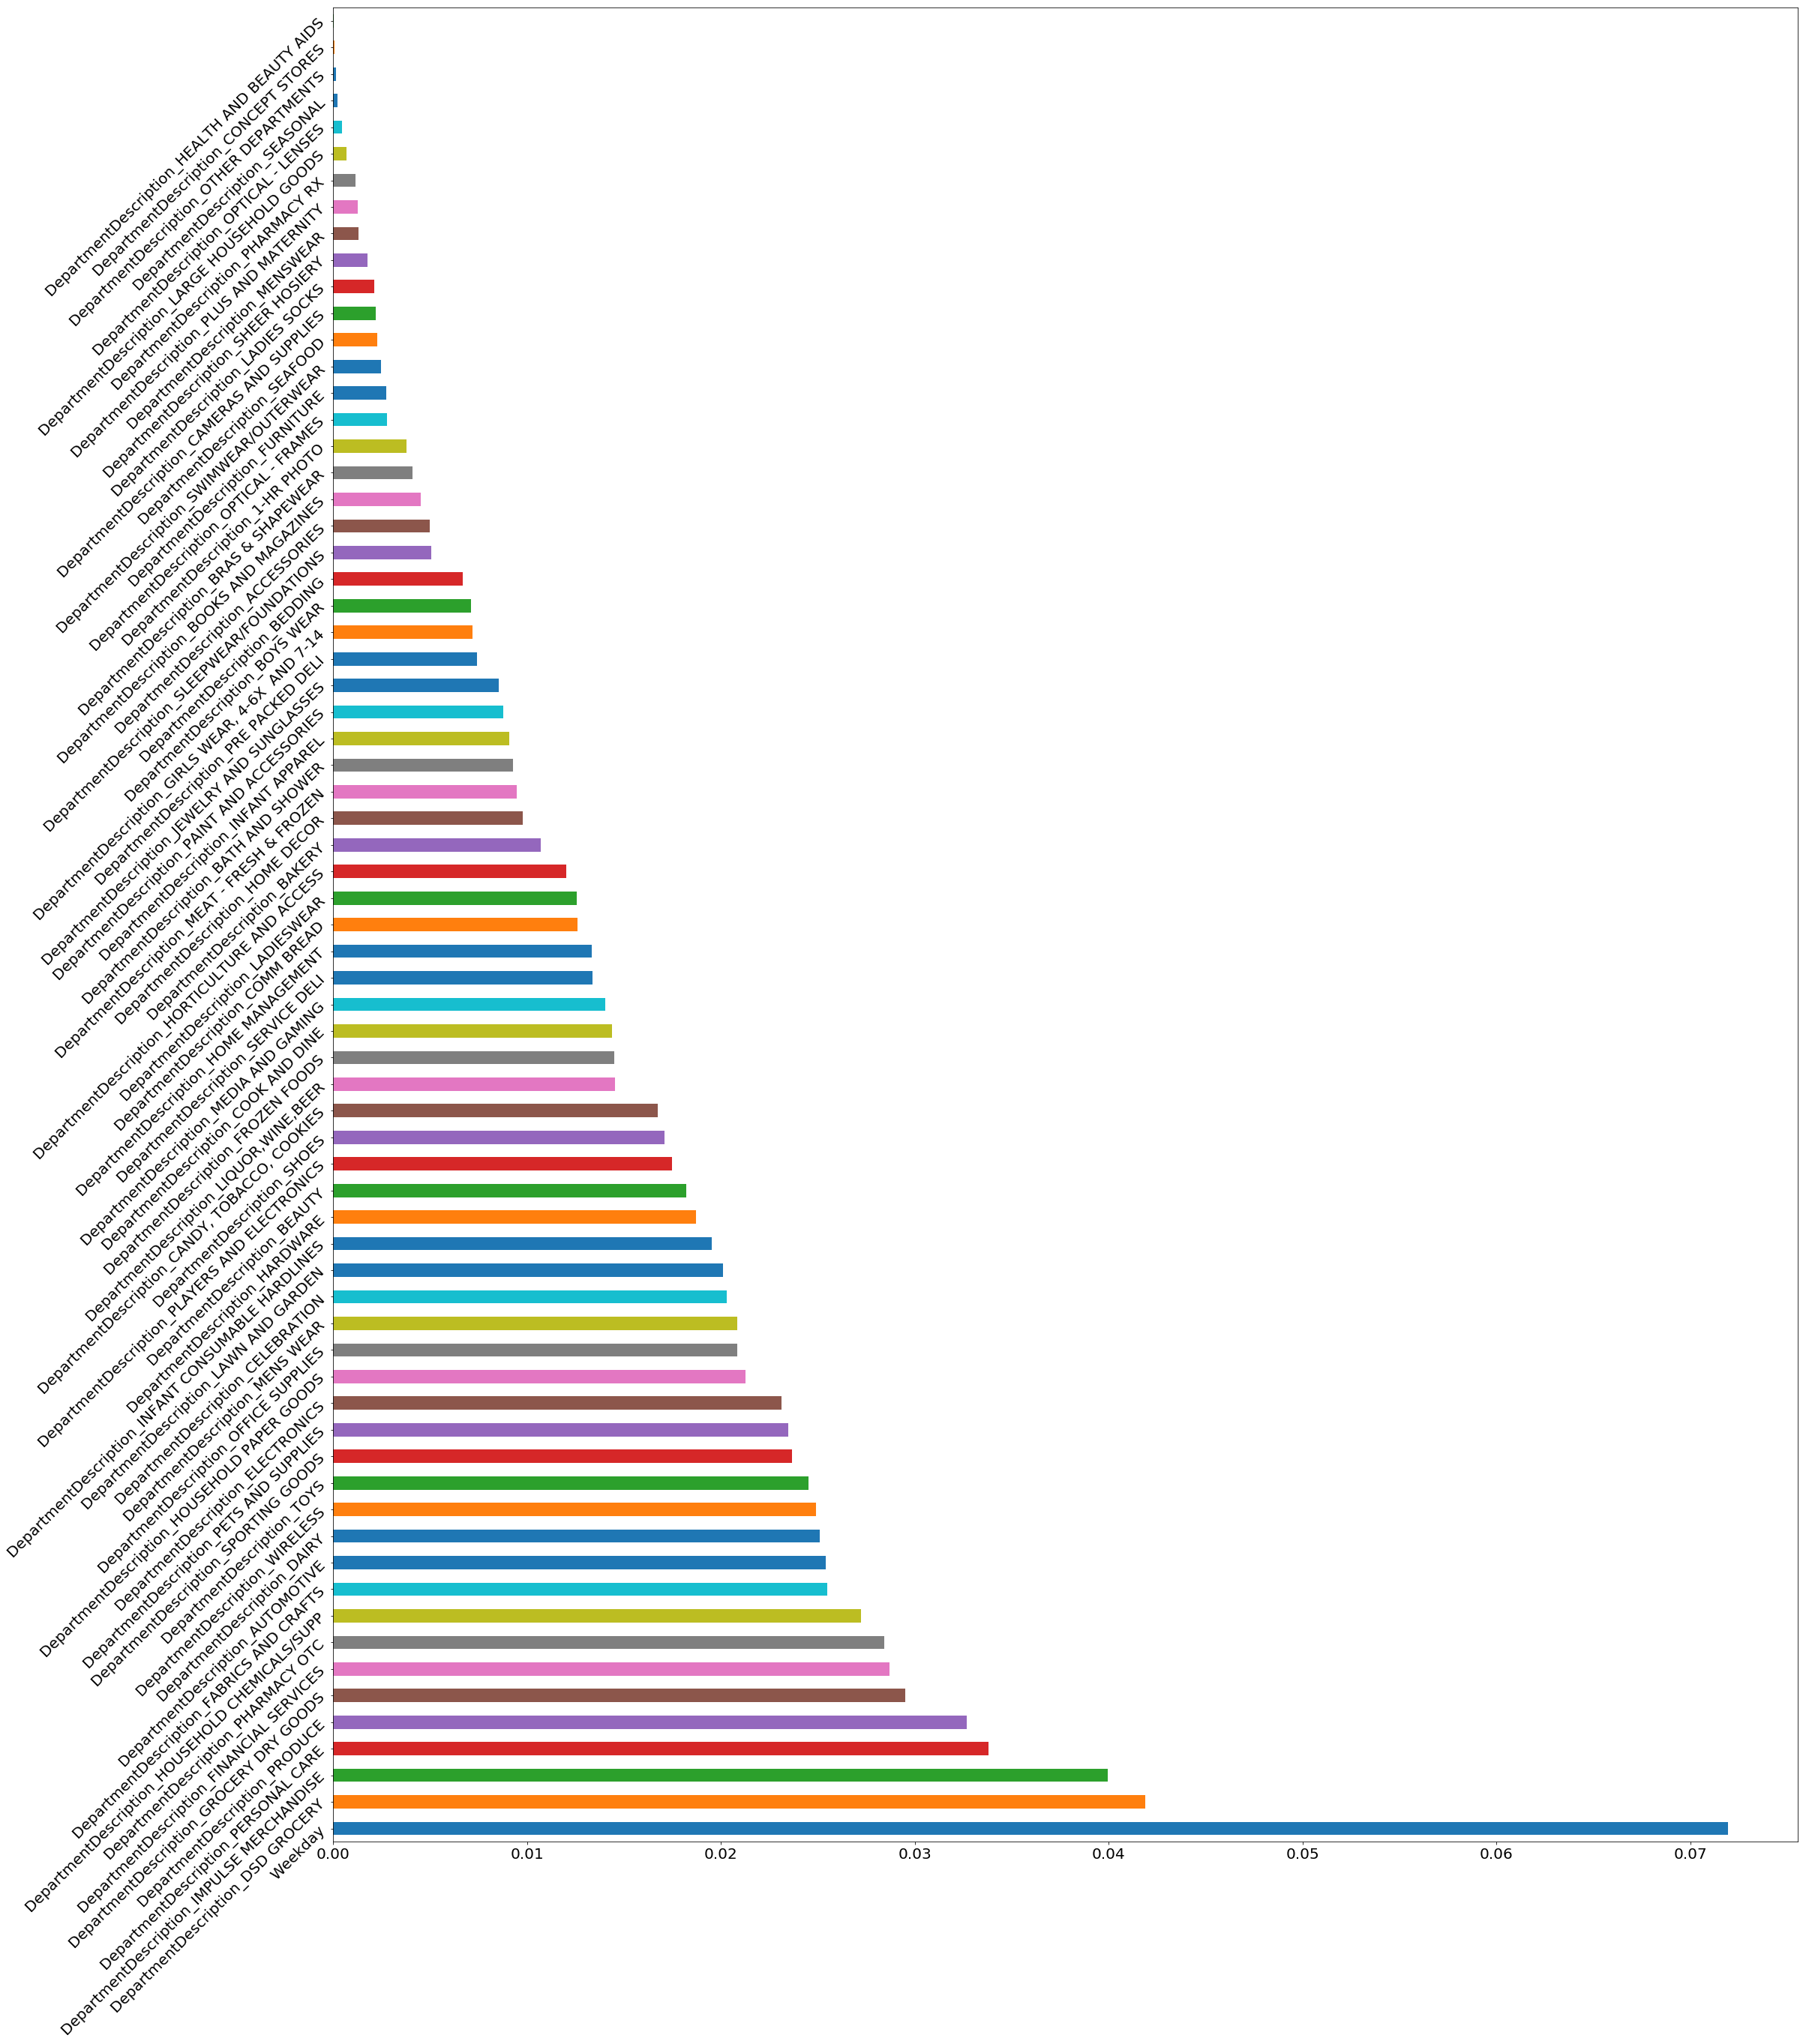

In [56]:
# Convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
f_importances = pd.Series(pipe_rf.named_steps['RandomForestClassifier'].feature_importances_, feature_value_names)

# Sort the array in descending order of the importances
f_importances = f_importances.sort_values(ascending=False)

# Draw the bar Plot from f_importances 
f_importances.plot(x='Importance', y='Features', kind='barh', figsize=(35,45), rot=45, fontsize=20)

#Show the plot

plt.show()

# Conclusion
<a id='Conclusion'></a>

After analyzing our models we found that Random Forest is the best model to predict Trip Type, it yielded an accuracy of 92.2%. Furthermore, we discovered that the best hyperparameters to use for this model were min_samples_leaf equal to 1, min_samples_split equal to 2 and n_estimators of 30. It is important to note that weekday is the root of the model to predict trip type. We also found that every department description is important (removing some, even of lesser importance resulted in a weaker model).